<a href="https://colab.research.google.com/github/XimenaLimon/4-methylphthalic-acid-and-its-related-anhydride/blob/main/4MPAc_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning applied to determine enthalpies of formation, combustion, and sublimation of 4-methylphthalic acid and its related anhydride.**

In [1]:
#Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# **Data reading**




1.   To predict the enthalpy of combustion, use the file *Combustion.csv*.
2.   To predict the enthalpy of formation in the gas phase, use the file *Formation_g.csv*.
3. To predict the enthalpy of formation in the crystalline phase, use the file *Formation_cr.csv*.
4. To predict the enthalpy of sublimation, use the file *Sublimation.csv*.



In [3]:
#Data set
Data=pd.read_csv("/content/drive/MyDrive/4mca/Combustion.csv")
pd.set_option("display.max_rows",None)

In this section, we extract the number of C, H, O, and N atoms from the empirical formula.

In [4]:
#Function to extract the number of atoms from the compact chemical formula
def parse_formula(formula):
    #Regular expression
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    element_counts = {}
    for (element, count) in matches:
        count = int(count) if count else 1  #If there is no number, 1 is assumed
        element_counts[element] = count
    return element_counts

#Processing of compact chemical formulas
formula_data = Data['Formula'].apply(parse_formula)

#Dataframe with the number of atoms
elements = pd.DataFrame(list(formula_data)).fillna(0)
Data=pd.concat([Data,elements],axis=1)

Here, we use the interquartile range criterion to identify the presence of outliers.

<Axes: ylabel='-∆fH°'>

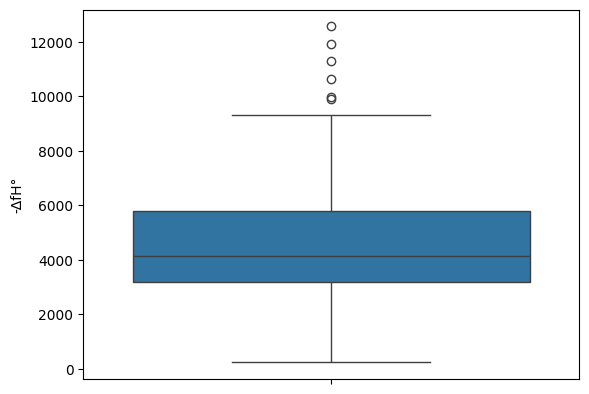

In [5]:
#Box plot shows outliers with interquartile range criteria
sns.boxplot(Data["-∆fH°"])

Once the outliers are identified, they are removed from the dataset using the Isolation Forest algorithm with 100 estimators.

1. For the combustion enthalpy dataset, use a
contamination rate of 0.11.
2. For the gas-phase formation enthalpy dataset, use a contamination rate of 0.01.
3. For the crystalline-phase formation enthalpy dataset, this step is not applied, as no outliers were identified.
4. For the sublimation enthalpy dataset, use a contamination rate of 0.02.

In [6]:
#Identification of outliers
#Combustion: contamination --> 0.11
#Formation gas phase: contamination --> 0.01
#Formation cr phase: contamination --> 0, because it has no outliers
#Sublimation: contamination --> 0.02
iso = IsolationForest(contamination=0.11, random_state=42)
Data['outliers'] = iso.fit_predict(Data[['-∆fH°']])
outliers = Data[Data['outliers'] == -1]
Data.drop(outliers.index, inplace=True)

We verify the removal of outliers by visualizing the box-and-whisker plot.

<Axes: ylabel='-∆fH°'>

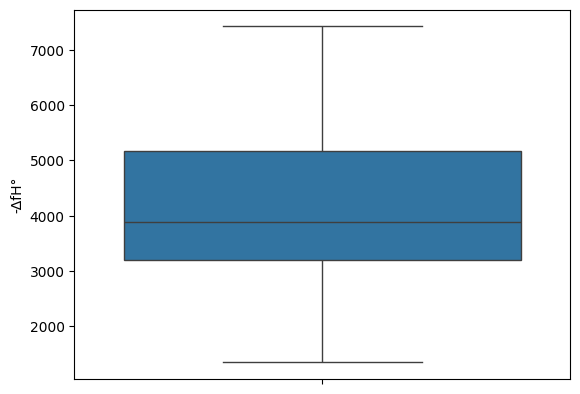

In [7]:
#Boxplot without outliers removed with isolation forest
sns.boxplot(Data["-∆fH°"])

From the preprocessed dataset, we select the predictor variables and the target variables.

In [8]:
#Definition of variables
X=Data.iloc[:,3:]
y=Data.iloc[:-1,2]

In [9]:
#Obtaining variables
pd.set_option("display.max_columns",None)
dummies=pd.get_dummies(X[["group","Correction 1","Correction 2","Correction 3","Correction 4"]], drop_first=True)
X=X.drop(["group","Correction 1","Correction 2","Correction 3","Correction 4"],axis=1)
C=pd.concat([X,dummies],axis=1)


In [10]:
#Compounds to predict
Compounds=C.iloc[:-1,:]
#predictions=C.loc[73,:]

#The number of data depends on the data set of each enthalpy that you want to predict.

#For Enthalpy of combustion use:
isomers=C.loc[95:,:]

#For Enthalpy of sublimation use:
#isomers=C.loc[72:,:]

#For Enthalpy of formation in gas phase use:
#isomers=C.loc[82:,:]

#For Enthalpy of formation in crystalline phase use:
#isomers=C.loc[98:,:]

We use the hold-out method to partition the dataset with a 70/30 split.

For each dataset, the following random states should be used:

1. Combustion enthalpy dataset: 427
2. Gas-phase formation enthalpy dataset: 644
3. Crystalline-phase formation enthalpy dataset: 329
4. Sublimation enthalpy dataset: 159

In [11]:
#Predictions with the best model
#random state = 427, alpha = 1 combustion
#random state = 644, alpha =  1.5 formation g phase
#random state = 329, alpha = 0.9 formation cr phase
#random state = 159, alpha = 0.95 sublimation
X_train, X_test, y_train, y_test = train_test_split(Compounds.drop(["outliers"],axis=1),y, test_size=0.3,
                                                    random_state=427)


We train the model using Ridge regression, varying the regularization parameter as follows:

1. For combustion enthalpy prediction, use *alpha = 1*.
2. For gas-phase formation enthalpy prediction, use *alpha = 1.5*.
3. For crystalline-phase formation enthalpy prediction, use *alpha = 0.9*.
4. For sublimation enthalpy prediction, use *alpha = 0.95*.

In [12]:
model=Ridge(alpha=1, solver="auto")
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


Here, we obtain the evaluation metrics.

In [13]:
#Evaluation metrics
rmse_train=root_mean_squared_error(y_train,y_pred_train)
rmse_test=root_mean_squared_error(y_test,y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"RMSE Test: {rmse_test}")
print(f"RMSE Train: {rmse_train}")
print(f"MAE Test: {mae_test}")
print(f"MAE Train: {mae_train}")
print(f"R2 Test: {r2_test}")
print(f"R2 Train: {r2_train}")

RMSE Test: 24.00797765451729
RMSE Train: 22.49608801797355
MAE Test: 17.172183219399987
MAE Train: 16.22349673869582
R2 Test: 0.9996550058569739
R2 Train: 0.9997818994661448


We obtain the learning curves.

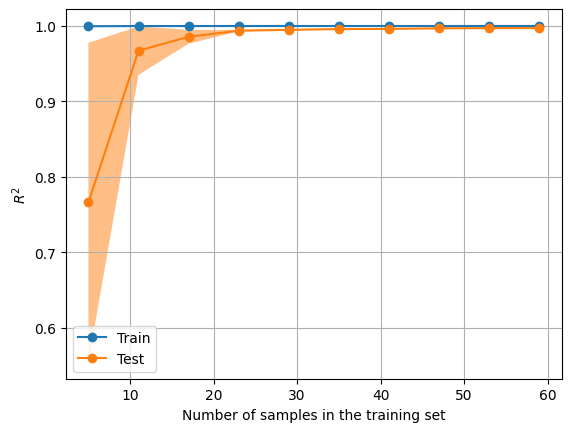

In [14]:
#Learning curve
common_params = {
    "X": Compounds.drop(["outliers"],axis=1),
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "$R^2$",
}

LearningCurveDisplay.from_estimator(model, **common_params)
plt.grid()
plt.show()

We obtain the parity plots for both the training and test datasets.

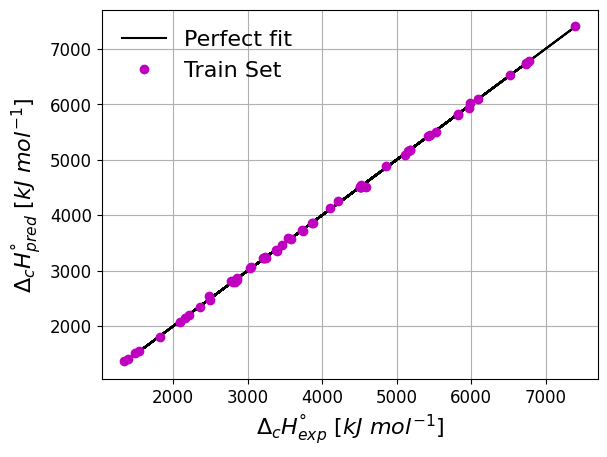

In [15]:
#Parity diagram for training set
plt.style.use('default')
plt.tick_params(labelsize=12)
plt.plot(y_train,y_train, "k-", label="Perfect fit")
plt.plot(y_train, y_pred_train, "mo", label="Train Set")
plt.xlabel("$\Delta_{c}H^{°}_{exp}$ $[kJ\ mol^{-1}$]", size=16)
plt.ylabel("$\Delta_{c}H^{°}_{pred}$ $[kJ\ mol^{-1}$]", size=16)
plt.grid()
plt.legend(loc="best", prop={"size":16}, frameon=False)
plt.show()

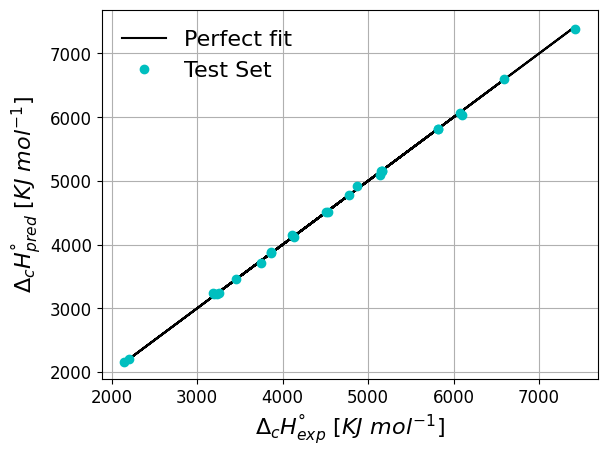

In [16]:
#Parity diagram for test set
plt.style.use('default')
plt.tick_params(labelsize=12)
plt.plot(y_test,y_test, "k-", label="Perfect fit")
plt.plot(y_test, y_pred_test, "co", label="Test Set")
plt.xlabel("$\Delta_{c}H^{°}_{exp}$ $[KJ\ mol^{-1}$]", size=16)
plt.ylabel("$\Delta_{c}H^{°}_{pred}$ $[KJ\ mol^{-1}$]", size=16)
plt.grid()
plt.legend(loc="best", prop={"size":16}, frameon=False)
plt.show()

Once the model's performance is ensured for both the training and test datasets, we retrain the model for each type of prediction using the entire respective dataset.

In [17]:
#Retrain the model with the data set
model=model.fit(Compounds.drop(["outliers"],axis=1),y)

We make predictions for the compounds of interest.

In [18]:
#y_compounds=model.predict([isomers.drop(index=["outliers"])])
y_compounds=model.predict(isomers.drop(["outliers"],axis=1))
print(y_compounds)

[3862.27401535 3893.71575252]



We obtain the contribution of each group and generate the output files.

In [19]:
#Contributions
Contribution=list(Compounds.columns)
coef=list(model.coef_)
Benson=pd.DataFrame(data=list(zip(Contribution, coef)), columns=["Group", "Value"])
model.intercept_.round(2)

-95.14

In [20]:
#We export the data
Benson.to_csv("Combustion_contributions.csv")